In [3]:
import os
import json
import pandas as pd

## chinchilla_isoflops

In [44]:
json_file = "../data/isoflops_curves.json"
df = pd.read_json(json_file)
df["tokens"] = df[["compute_budget", "parameters"]].apply(lambda x: int(x.compute_budget / x.parameters), axis=1)
df.head()

,parameters,compute_budget,final_loss,tokens
0,49999999,6.000000e+18,7.192785,120000002400
1,78730505,6.000000e+18,6.750171,76209342236
2,123969849,6.000000e+18,6.406640,48398865114
3,195204177,6.000000e+18,6.154369,30737047189
4,307370470,6.000000e+18,5.987783,19520417820


In [45]:
# Select rows with minimum final_loss for each compute_budget
df_min_loss = df.loc[df.groupby("compute_budget")["final_loss"].idxmin()]

# Apply log transformation to parameters and compute_budget columns
import numpy as np
df_min_loss['log_parameters'] = np.log10(df_min_loss['parameters'])
df_min_loss['log_tokens'] = np.log10(df_min_loss['tokens'])
df_min_loss['log_compute_budget'] = np.log10(df_min_loss['compute_budget'])

df_min_loss

,parameters,compute_budget,final_loss,tokens,log_parameters,log_tokens,log_compute_budget
6,762093419,6.000000e+18,5.899930,7873050534,8.882008,9.896143,18.778151
13,806647749,1.000000e+19,5.617943,12396984944,8.906684,10.093316,19.000000
20,1536852354,3.000000e+19,5.107177,19520417769,9.186632,10.290489,19.477121
27,1952041776,6.000000e+19,4.830586,30737047094,9.290489,10.487662,19.778151
35,3253402960,1.000000e+20,4.652893,30737047094,9.512338,10.487662,20.000000
46,5903836027,3.000000e+20,4.311219,50814419409,9.771134,10.705987,20.477121
53,6971055968,6.000000e+20,4.121241,86070173981,9.843299,10.934853,20.778151
60,6859328563,1.000000e+21,4.002835,145786863949,9.836282,11.163718,21.000000
67,12148905329,3.000000e+21,3.773188,246935828270,10.084537,11.392584,21.477121


Fitted line: log_parameters = 0.4687 * log_compute_budget + 0.0657
Extrapolated: [10.37675172 10.84543439 11.31411706]
Fitted line: log_tokens = 0.5313 * log_compute_budget + -0.0657
Extrapolated: [11.62324828 12.15456562 12.68588295]


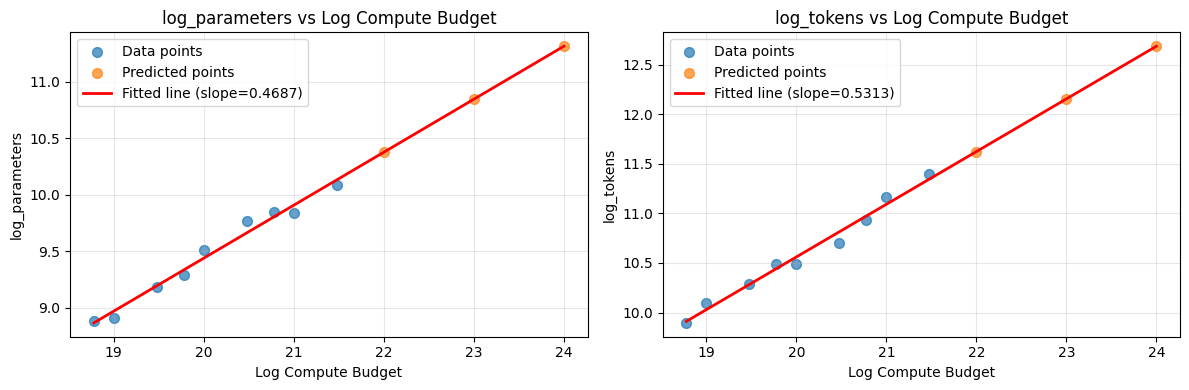

In [50]:
# Fit a line using scipy.optimize.curve_fit
import scipy.optimize
import matplotlib.pyplot as plt

# Define a linear function for fitting
def linear_function(x, a, b):
    """Linear function: y = a*x + b"""
    return a * x + b

# Create subplots side by side
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

for i, y_ft in enumerate(["log_parameters", "log_tokens"]):
    # Extract x and y data
    x_data = df_min_loss['log_compute_budget'].values
    y_data = df_min_loss[y_ft].values

    # Perform the curve fitting
    popt, pcov = scipy.optimize.curve_fit(linear_function, x_data, y_data)
    slope, intercept = popt

    print(f"Fitted line: {y_ft} = {slope:.4f} * log_compute_budget + {intercept:.4f}")

    # add new x data for extrapolation
    new_x_data = np.array([22, 23, 24])
    all_x_data = np.append(x_data, new_x_data)
    y_pred = linear_function(all_x_data, slope, intercept)
    new_y_pred = linear_function(new_x_data, slope, intercept)
    print(f"Extrapolated: {new_y_pred}")

    # Plot the data and fitted line on the appropriate subplot
    ax = axes[i]
    ax.scatter(x_data, y_data, alpha=0.7, s=50, label='Data points')
    ax.scatter(new_x_data, new_y_pred, alpha=0.7, s=50, label='Predicted points')
    ax.plot(all_x_data, y_pred, 'r-', linewidth=2, label=f'Fitted line (slope={slope:.4f})')
    ax.set_xlabel('Log Compute Budget')
    ax.set_ylabel(f'{y_ft}')
    ax.set_title(f'{y_ft} vs Log Compute Budget')
    ax.legend()
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()